## Parsing Mini-EUSO log files

In [111]:
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, time

In [112]:
filename = 'CPU_MAIN__2019_10_07__18_46_59.log'
search_str = 'average photodiode reading is:'
day_str = 'entering DAY mode'
night_str = 'entering NIGHT mode'

In [113]:
# Set date
my_day = datetime.date(2019, 10, 7)

In [147]:
# Grab photodiode read logs, ignoring ones that get cut off
lines = [line.rstrip('\n') for line in open(filename) if 
         ((search_str in line) and (len(line) > 65))]

# Grab DAY/NIGHT siwtching times
day_lines = [line.rstrip('\n') for line in open(filename) if 
             day_str in line]
night_lines = [line.rstrip('\n') for line in open(filename) if 
               (night_str in line and len(line)>26)]

In [148]:
# loop through and parse details (timestamp and photodiode value)
day = []
timestamp = []
photodiode = []
for l in lines:
    day.append(datetime.date(int(l[0:4]), int(l[5:7]), int(l[8:10])))
    ts = l[11:26]
    timestamp.append(time(hour=int(ts[0:2]), minute=int(ts[3:5]), 
                          second=int(ts[6:8]), microsecond=int(ts[9:15])))
    photodiode.append(float(l[-2:]))

# Combine day and timestamp
x_dt = [ datetime.datetime.combine(d, t) for d, t in zip(day, timestamp) ]

In [157]:
# Parse switching times
day = []
day_switch = []
for l in day_lines:
    test = datetime.date(int(l[0:4]), int(l[5:7]), int(l[8:10]))
    day.append(test)
    ts = l[11:26]
    day_switch.append(time(hour=int(ts[0:2]), minute=int(ts[3:5]), 
                              second=int(ts[6:8]), microsecond=int(ts[9:15])))
x_day = [ datetime.datetime.combine(d, t) for d, t in zip(day, day_switch) ]

day = []
night_switch = []
for l in night_lines:
    day.append(datetime.date(int(l[0:4]), int(l[5:7]), int(l[8:10])))
    ts = l[11:26]
    night_switch.append(time(hour=int(ts[0:2]), minute=int(ts[3:5]), 
                              second=int(ts[6:8]), microsecond=int(ts[9:15])))
    
# Combine day and timestamp

x_night = [ datetime.datetime.combine(d, t) for d, t in zip(day, night_switch) ]

## Plot results

In [158]:
plt.style.use('minimalist')

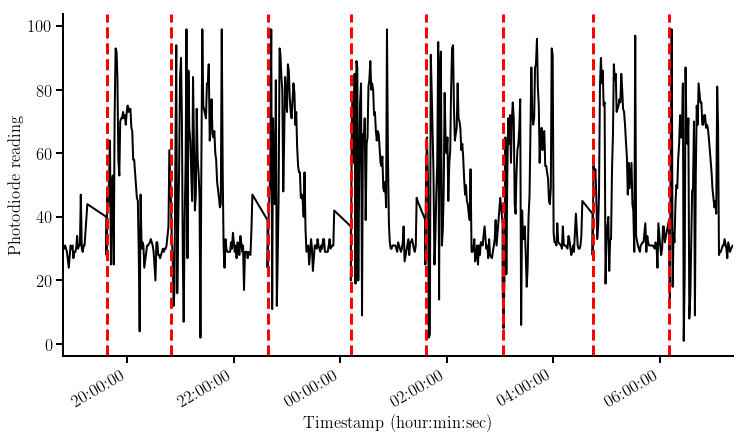

In [201]:
fig, ax = plt.subplots()
fig.set_size_inches((12, 7))
ax.plot(x_dt, photodiode, 'k')
for d in x_day:
    ax.axvline(d, color='r', linestyle='--', lw=3)
#for n in x_night:
#    ax.axvline(n, color='g', linestyle='--', lw=3)
myFmt = mdates.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()
ax.set_xlabel('Timestamp (hour:min:sec)')
ax.set_ylabel('Photodiode reading')
ax.set_xlim(x_dt[0])
fig.savefig('photodiode_timeseries.pdf', dpi=500, bbox_inches='tight')

## Mean time between high photodiode value and switch

In [191]:
threshold = 45 # ?

In [200]:
# Find timestamps of first threshold crossing
crossing = []
#for day in x_day:
    #print([d for i, d in enumerate(x_dt) if d < day and photodiode[i]>threshold])